In [12]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Join All Hourly Data

In [32]:
# setting the path for joining multiple files
files = os.path.join("../data/epa/TXHOURLY", "*tx*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
cols = ['ORISPL_CODE', 'UNITID', 'OP_HOUR', 'GLOAD (MW)', 'SO2_RATE (lbs/mmBtu)',
       'NOX_RATE (lbs/mmBtu)', 'CO2_RATE (tons/mmBtu)', 'HEAT_INPUT (mmBtu)']
df = df[cols]
df.dropna(inplace=True)

Resultant CSV after joining all CSV files at a particular location...


In [33]:
d = df.loc[df.OP_HOUR ==1]
d = pd.get_dummies(d, columns=['ORISPL_CODE', 'UNITID'])
print(d.columns)
X = d.drop('CO2_RATE (tons/mmBtu)', axis=1).to_numpy()
y = d['CO2_RATE (tons/mmBtu)'].to_numpy()

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Index(['OP_HOUR', 'GLOAD (MW)', 'SO2_RATE (lbs/mmBtu)', 'NOX_RATE (lbs/mmBtu)',
       'CO2_RATE (tons/mmBtu)', 'HEAT_INPUT (mmBtu)', 'ORISPL_CODE_127',
       'ORISPL_CODE_298', 'ORISPL_CODE_3439', 'ORISPL_CODE_3441',
       ...
       'UNITID_U5', 'UNITID_U6', 'UNITID_WAP1', 'UNITID_WAP2', 'UNITID_WAP3',
       'UNITID_WAP4', 'UNITID_WAP5', 'UNITID_WAP6', 'UNITID_WAP7',
       'UNITID_WAP8'],
      dtype='object', length=283)


## Make Model Flat

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [35]:
model.coef_

array([-5.62062948e-16,  1.16742475e-05,  3.97126439e-03,  2.50369864e-02,
       -2.93773117e-07,  2.99553834e-02,  2.21287884e-02, -4.68927802e-03,
       -2.77810810e-03, -2.72896704e-03, -7.24662434e-03, -2.07713123e-03,
       -8.90401425e-03, -5.56402130e-03, -8.19367377e-03, -3.53967529e-03,
        9.91833156e-03, -7.37213356e-03, -8.93719333e-03, -6.75836754e-03,
       -4.90591340e-03, -4.53774873e-03, -6.55023902e-03, -8.16037104e-03,
       -5.89062974e-03, -6.67167367e-03, -3.91359447e-03, -7.65693904e-03,
       -2.42061519e-03, -6.64030093e-03, -2.28417215e-03, -1.96551089e-03,
       -8.15434467e-03, -7.97889072e-03, -6.81330286e-03, -6.13648857e-04,
       -6.39572119e-03, -6.32118570e-03, -2.51792763e-03, -6.75188927e-03,
        3.28715402e-02,  3.53830921e-02,  3.36257385e-02,  3.48759974e-02,
        3.55484904e-02,  1.79454374e-02,  2.21795991e-02,  1.96107902e-02,
       -6.20778072e-03,  3.61989437e-02,  2.30735423e-02, -2.92744355e-03,
       -2.84755573e-03, -

## Make Model Score

In [36]:
print("Mean squared error: %.6f" % mean_squared_error(y_test, pred))

Mean squared error: 0.000014


(-0.02, 0.02)

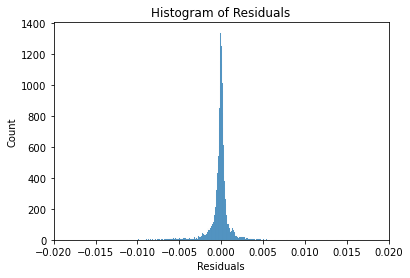

In [38]:
sns.histplot(pred-y_test)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.xlim(-0.02, 0.02)

Text(0.5, 1.0, 'CO2_RATE (tons/mmBtu) Distribution')

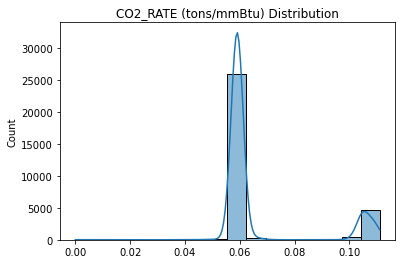

In [39]:
sns.histplot(y_test, kde=True)
plt.title("CO2_RATE (tons/mmBtu) Distribution")

/opt/anaconda3/envs/science/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/var/folders/dj/7rxcfclj40n7c9yj3nbllqy00000gn/T/ipykernel_13150/2103072131.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "background" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("CO2_LinReg.png", background="white")


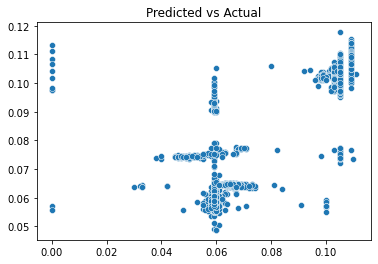

In [40]:
sns.scatterplot(y_test, pred)
plt.title("Predicted vs Actual")
plt.savefig("CO2_LinReg.png", background="white")